In [1]:
%matplotlib inline
import cv2
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy.fft as fft
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
# https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
# https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html

def find_largest_region(arr):
    binary_arr = np.zeros(arr.shape, 'uint8')
    binary_arr[arr != 0] = 1
    label_arr, nb_labels = nd.label(binary_arr)
    sizes = nd.sum(binary_arr, label_arr, range(nb_labels + 1))
    max_label = sizes.argmax()
    label_arr[label_arr != max_label] = 0
    label_arr[label_arr != 0] = 1
    return label_arr


def load_geotiff(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    data = ds.GetRasterBand(band).ReadAsArray()
    nodata = ds.GetRasterBand(band).GetNoDataValue()
    mask = data == nodata
    data = np.ma.array(data, mask=mask, fill_value=-9999)
    projection = ds.GetProjection()
    transform = ds.GetGeoTransform()
    ds = None
    return data, transform, projection

def find_largest_region(arr):
    binary_arr = np.zeros(arr.shape)
    binary_arr[arr != 0] = 1
    label_arr, nb_labels = nd.label(binary_arr)
    sizes = nd.sum(binary_arr, label_arr, range(nb_labels + 1))
    max_label = sizes.argmax()
    label_arr[label_arr != max_label] = 0
    return label_arr


def wallis_filter(Ix, filter_width):
    kernel = np.ones((filter_width, filter_width), dtype=np.float32)
    n = np.sum(kernel)
    m = cv2.filter2D(Ix, -1, kernel, borderType=cv2.BORDER_CONSTANT) / n

    m2 = cv2.filter2D(Ix ** 2, -1, kernel, borderType=cv2.BORDER_CONSTANT) / n
    std = np.sqrt(m2 - (m ** 2)) * np.sqrt(n / (n - 1))
    filtered = (Ix - m) / std
    return filtered


In [ ]:
# img = np.zeros((5000,5000))
# img[1500:3000,1000:4000] = 1
# rot = 0.3
# affine = [[np.cos(rot), -np.sin(rot),  0],
#           [0.3*np.sin(rot),np.cos(rot),0],
#           [0,0,1]]
#
# img = nd.affine_transform(img, affine)
# img = (img > 0.05).astype(int)
# plt.imshow(img)

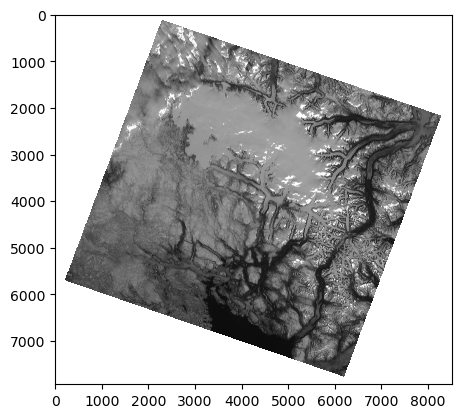

In [7]:
img, trans, proj = load_geotiff('./scenes/LT05_L2SP_018013_20060610_20200901_02_T1_SR_B2.TIF')
plt.imshow(img)

/var/folders/v6/09104kyj1mb4j8hcd8t03_rw0000gq/T/ipykernel_18306/4160636722.py:44: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(m2 - (m ** 2)) * np.sqrt(n / (n - 1))


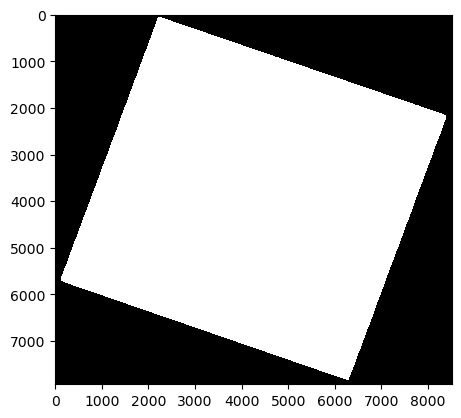

In [8]:
valid_domain = np.array(~img.mask)
Ix = np.array(img.filled(fill_value=0.0)).astype(float)

wallis = wallis_filter(img, filter_width=5)
wallis[~valid_domain] = 0
plt.imshow(wallis)

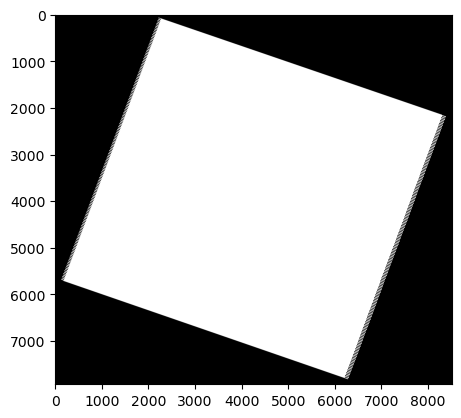

In [9]:
single_region = find_largest_region(wallis)
single_region = np.uint8(single_region * 255)
plt.imshow(single_region)

In [32]:
contours, hierarchy = cv2.findContours(single_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)

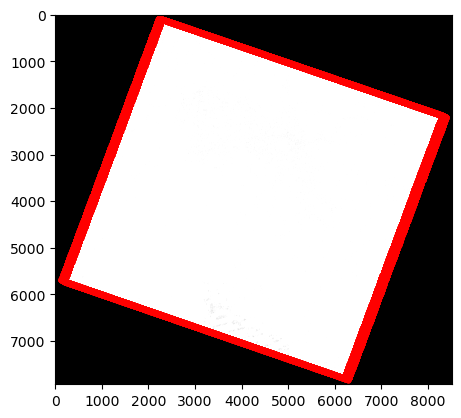

In [27]:
f, ax = plt.subplots(1,1)
ax.imshow(single_region)
ax.scatter(cnt[:,:,0], cnt[:,:,1], color='red', s=10)

((4255.091796875, 3945.076904296875), (6658.47900390625, 6017.2890625), 19.059099197387695)


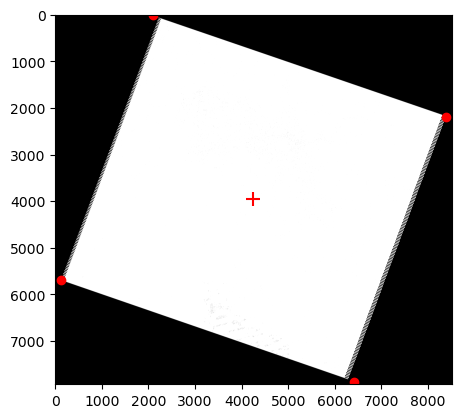

In [28]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
f, ax = plt.subplots(1,1)
ax.imshow(single_region)
ax.scatter(box[:,0], box[:,1], color='red')
ax.scatter(cx, cy, color='red', marker='+', s=100)
print(rect)

In [26]:
rect

((4255.091796875, 3945.076904296875),
 (6658.47900390625, 6017.2890625),
 19.059099197387695)

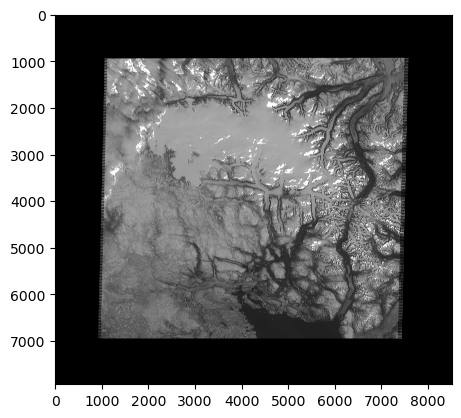

In [12]:
rotated = nd.rotate(img,rect[2],reshape=False)
plt.imshow(rotated)

In [53]:
m, n = img.shape
angle =rect[2]
center_m = int(np.floor(m / 2))
center_n = int(np.floor(n / 2))
filter_base = np.full((m,n), False)
filter_base[center_m - 70:center_m + 70, :] = 1
filter_base[:, center_n - 100:center_n + 100] = 0

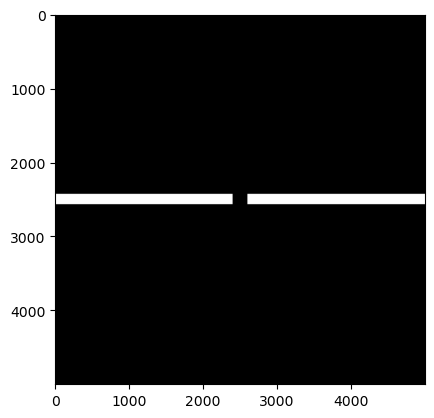

In [54]:
plt.imshow(filter_base)

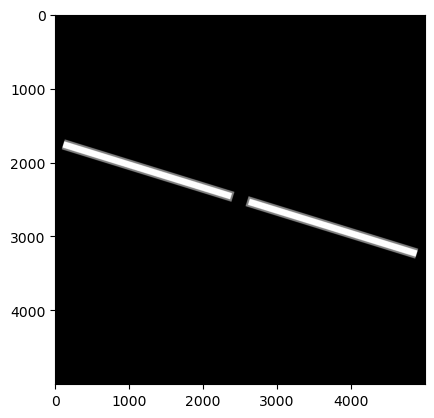

In [55]:
filter_a = nd.rotate(filter_base, -angle, reshape=False)
plt.imshow(filter_a)

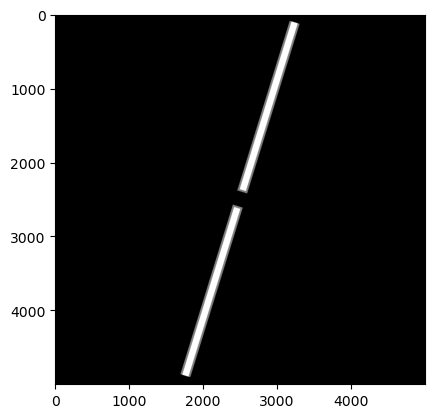

In [56]:
filter_b = nd.rotate(filter_base, 90-angle, reshape=False)
plt.imshow(filter_b)

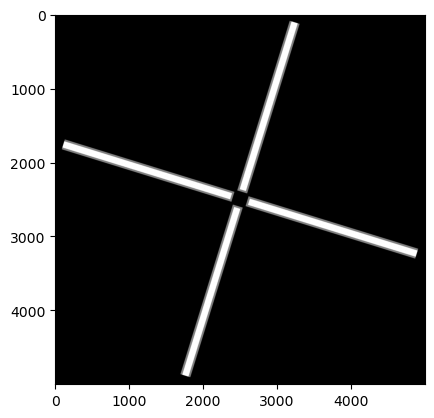

In [59]:
plt.imshow(filter_a+filter_b)

# Comparison